In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import jieba
import re

In [2]:
# import data
chatgpt_post = pd.read_csv('../Data/ChatGPT/chatgpt_generated_articles.csv')['content']
ptt_post = pd.read_csv('../Data/Ptt/ptt_food_post_list.csv')['content']

In [3]:
def process_gpt_text(text):
    text = text.split('\n\n', 1)[-1]
    text = text.replace('\n', '')
    return text

In [4]:
chatgpt_post = chatgpt_post.apply(process_gpt_text)

In [5]:
# Data preprocessing
def full_to_half(s):
    # 將字符串 s 中的全形字符和標點符號轉換為半形。
    n = []
    for char in s:
        code = ord(char)
        if code == 0x3000:  # 全形空格直接轉換
            code = 32
        elif 0xFF01 <= code <= 0xFF5E:  # 全形字符（除空格）轉換成半形
            code -= 0xFEE0
        n.append(chr(code))
    return ''.join(n)

def remove_urls_and_phones(text):
    """
    移除文字中的網址和電話號碼。
    """
    # 正則表達式匹配網址
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)

    # 正則表達式匹配電話號碼（適用於多種常見格式）
    phone_pattern = r'(\d{2,4}[-.\s]??\d{3,4}[-.\s]??\d{3,4}|\(\d{2,4}\)\s*\d{3,4}[-.\s]??\d{3,4}|\d{10,11})'
    text = re.sub(phone_pattern, '', text)

    return text

def remove_english(text):
    """
    移除文字中的所有英文字符。
    """
    # 正則表達式匹配所有英文字母和英文單詞
    pattern = r'[A-Za-z]+'
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

def remove_emojis(text):
    emoji_pattern = re.compile(
        "[" 
        "\U0001F600-\U0001F64F"  # 表情符號
        "\U0001F300-\U0001F5FF"  # 符號和圖案
        "\U0001F680-\U0001F6FF"  # 交通和符號
        "\U0001F700-\U0001F77F"  # 藝術符號
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

def load_dictionary(file_path):
    with open(file_path, encoding='utf-8', mode='r') as f:
        dictionary = [l.strip() for l in f]
    return dictionary

def remove_stopwords(text, stopwords):
    # 使用列表推導式過濾掉停用詞
    filtered_words = remove_urls_and_phones(text)
    filtered_words = remove_english(filtered_words)
    filtered_words = remove_emojis(filtered_words)
    filtered_words = "".join(c for c in filtered_words if c not in ('；','，','。','！','：','「','」','…','、','？','【','】','.',':','?',';','!','~','`','+','-','<','>','/','[',']','{','}',"'",'"','\\', ' ', '‧','・','◢','◤','\n','★','☆','◆','◇','◎','○','●','◐','◑','▲','▼','△','▽','◢','◣','◥','◤','▷','◁','▶','◀','♠','♣','♥','♦','♨','⊙','⊕','▨','▧','▦','▥','▤','▣','▢','□','■'))
    filtered_words = "".join(word for word in filtered_words if word not in stopwords)
    filtered_words = filtered_words.replace(u'\u3000', u' ')
    # 將過濾後的單詞列表重新組合成字符串
    return filtered_words



In [6]:
df_gpt = pd.DataFrame({'content': chatgpt_post, 'label': 1})
df_ptt = pd.DataFrame({'content': ptt_post, 'label': 0})

# Concatenate the DataFrames
all_post = pd.concat([df_gpt, df_ptt], ignore_index=True)
all_post = all_post.sample(frac=1).reset_index(drop=True)

In [7]:
with open('../Data/stopwords_tc.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

def split_words(text):
    words = list(jieba.cut(text))
    words = [word for word in words if word.strip() and word not in stopwords]
    return words

In [8]:
# Apply the process to all data
chatgpt_post = chatgpt_post.apply(process_gpt_text)
df_gpt = pd.DataFrame({'content': chatgpt_post, 'label': 1})
df_ptt = pd.DataFrame({'content': ptt_post, 'label': 0})

# Concatenate the DataFrames
all_post = pd.concat([df_gpt, df_ptt], ignore_index=True)
all_post = all_post.sample(frac=1).reset_index(drop=True)

# Data preprocessing
remove_stopwords_contents = []
for content in all_post['content']:
    remove_stopwords_contents.append(remove_stopwords(content, stopwords))

all_post['content'] = remove_stopwords_contents

word_data = []

for idx, row in all_post.iterrows():
    words = split_words(row['content'])
    for word_id, word in enumerate(words):
        word_data.append({
            'post_id': idx,
            'word_id': word_id,
            'word_content': word,
            'label': row['label']
        })

df_words = pd.DataFrame(word_data)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Extract the content for each word
df_words['word_content'] = df_words['word_content'].astype(str)

# Train/test split for post_id
post_ids = df_words['post_id'].unique()
train_ids, test_ids = train_test_split(post_ids, test_size=0.2, random_state=42)

# Prepare the DataFrame for train/test sets
train_df = df_words[df_words['post_id'].isin(train_ids)]
test_df = df_words[df_words['post_id'].isin(test_ids)]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.435 seconds.
Prefix dict has been built successfully.


In [9]:
def filter_words_strict(df, word_count):
    filtered_df = df[df['word_id'] < word_count]
    valid_post_ids = filtered_df['post_id'].value_counts()
    valid_post_ids = valid_post_ids[valid_post_ids == word_count].index
    return filtered_df[filtered_df['post_id'].isin(valid_post_ids)]

#### build model

In [10]:
max_num_words = 60

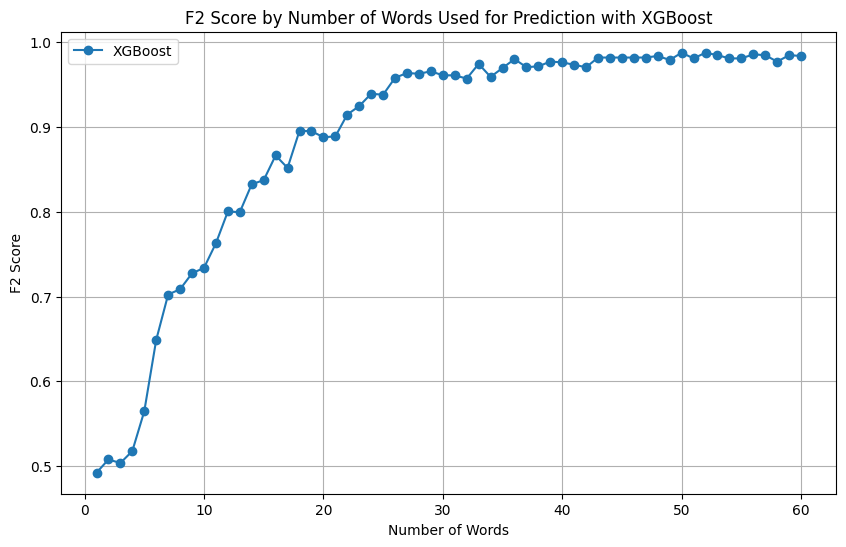

In [11]:
# Initialize lists to store results
f2_scores_xgb = []

# Iterate through word counts
for word_count in range(1, max_num_words+1):
    # Filter words ensuring each post_id has exactly the required number of words
    train_words = filter_words_strict(train_df, word_count)
    test_words = filter_words_strict(test_df, word_count)

    if train_words.empty or test_words.empty:
        f2_scores_xgb.append(0)
        continue

    # Group words by post_id
    train_grouped = train_words.groupby('post_id')['word_content'].apply(' '.join)
    test_grouped = test_words.groupby('post_id')['word_content'].apply(' '.join)

    # Get the labels
    train_labels = train_words.groupby('post_id')['label'].first()
    test_labels = test_words.groupby('post_id')['label'].first()

    # TF-IDF Vectorization
    X_train = vectorizer.fit_transform(train_grouped)
    X_test = vectorizer.transform(test_grouped)

    # Convert the data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=train_labels)
    dtest = xgb.DMatrix(X_test, label=test_labels)

    # Set up parameters for XGBoost
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'eta': 0.1,
        'seed': 42
    }

    # Train the model
    bst = xgb.train(params, dtrain, num_boost_round=100)

    # Predict and calculate F2-score
    predictions = bst.predict(dtest)
    predictions = [1 if pred > 0.5 else 0 for pred in predictions]
    f2 = fbeta_score(test_labels, predictions, beta=2)

    # Store the F2-score
    f2_scores_xgb.append(f2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_num_words+1), f2_scores_xgb, marker='o', label='XGBoost')
plt.xlabel('Number of Words')
plt.ylabel('F2 Score')
plt.title('F2 Score by Number of Words Used for Prediction with XGBoost')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

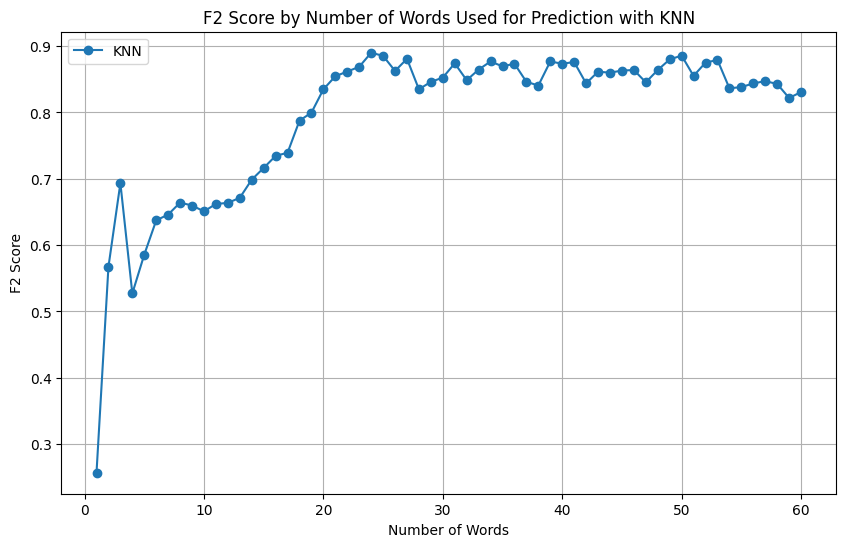

In [12]:
# Initialize lists to store results
f2_scores_knn = []

# Iterate through word counts
for word_count in range(1, max_num_words+1):
    # Filter words ensuring each post_id has exactly the required number of words
    train_words = filter_words_strict(train_df, word_count)
    test_words = filter_words_strict(test_df, word_count)

    if train_words.empty or test_words.empty:
        f2_scores_knn.append(0)
        continue

    # Group words by post_id
    train_grouped = train_words.groupby('post_id')['word_content'].apply(' '.join)
    test_grouped = test_words.groupby('post_id')['word_content'].apply(' '.join)

    # Get the labels
    train_labels = train_words.groupby('post_id')['label'].first()
    test_labels = test_words.groupby('post_id')['label'].first()

    # TF-IDF Vectorization
    X_train = vectorizer.fit_transform(train_grouped)
    X_test = vectorizer.transform(test_grouped)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=50)  # Retain 95% of variance
    X_train = pca.fit_transform(X_train.toarray())
    X_test = pca.transform(X_test.toarray())

    # Train a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, train_labels)

    # Predict and calculate F2-score
    predictions = knn.predict(X_test)
    f2 = fbeta_score(test_labels, predictions, beta=2)

    # Store the F2-score
    f2_scores_knn.append(f2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_num_words+1), f2_scores_knn, marker='o', label='KNN')
plt.xlabel('Number of Words')
plt.ylabel('F2 Score')
plt.title('F2 Score by Number of Words Used for Prediction with KNN')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


Epoch [10/100], Loss: 0.6344
Epoch [20/100], Loss: 0.5671
Epoch [30/100], Loss: 0.5534
Epoch [40/100], Loss: 0.5508
Epoch [50/100], Loss: 0.5507
Epoch [60/100], Loss: 0.5503
Epoch [70/100], Loss: 0.5503
Epoch [80/100], Loss: 0.5502
Epoch [90/100], Loss: 0.5501
Epoch [100/100], Loss: 0.5507
Epoch [10/100], Loss: 0.6127
Epoch [20/100], Loss: 0.4829
Epoch [30/100], Loss: 0.4691
Epoch [40/100], Loss: 0.4672
Epoch [50/100], Loss: 0.4666
Epoch [60/100], Loss: 0.4661
Epoch [70/100], Loss: 0.4661
Epoch [80/100], Loss: 0.4666
Epoch [90/100], Loss: 0.4666
Epoch [100/100], Loss: 0.4662
Epoch [10/100], Loss: 0.6003
Epoch [20/100], Loss: 0.3039
Epoch [30/100], Loss: 0.2823
Epoch [40/100], Loss: 0.2777
Epoch [50/100], Loss: 0.2767
Epoch [60/100], Loss: 0.2760
Epoch [70/100], Loss: 0.2757
Epoch [80/100], Loss: 0.2754
Epoch [90/100], Loss: 0.2752
Epoch [100/100], Loss: 0.2751
Epoch [10/100], Loss: 0.5949
Epoch [20/100], Loss: 0.2548
Epoch [30/100], Loss: 0.2268
Epoch [40/100], Loss: 0.2175
Epoch [50/1

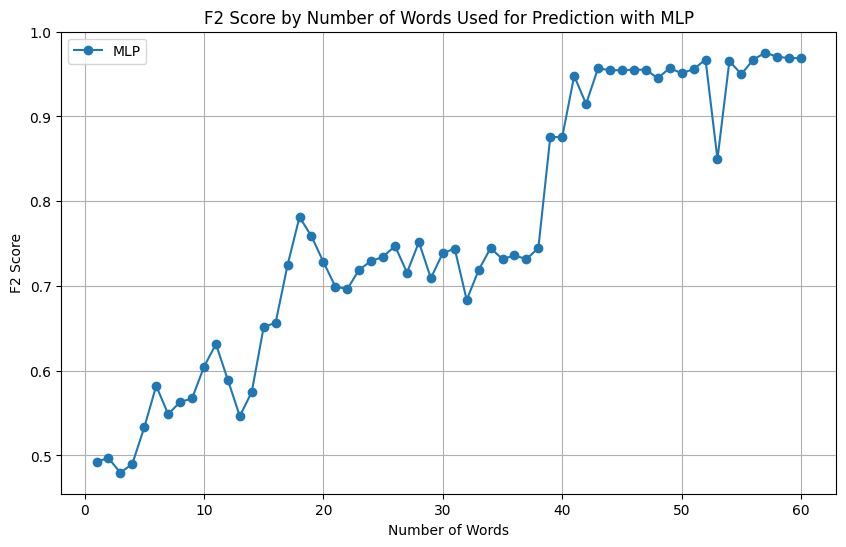

In [13]:
f2_scores_mlp = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for word_count in range(1, max_num_words+1):
    torch.cuda.empty_cache()

    train_words = filter_words_strict(train_df, word_count)
    test_words = filter_words_strict(test_df, word_count)

    if train_words.empty or test_words.empty:
        f2_scores_mlp.append(0)
        continue

    train_grouped = train_words.groupby('post_id')['word_content'].apply(lambda x: ' '.join(x))
    test_grouped = test_words.groupby('post_id')['word_content'].apply(lambda x: ' '.join(x))
    train_labels = train_words.groupby('post_id')['label'].first()
    test_labels = test_words.groupby('post_id')['label'].first()

    X_train = vectorizer.fit_transform(train_grouped)
    X_test = vectorizer.transform(test_grouped)

    # 將數據轉換為Tensor
    X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1).to(device)
    y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32).view(-1, 1).to(device)

    # 建立MLP模型
    input_size = X_train_tensor.shape[1]
    model = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    # 定義損失函數和優化器
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 訓練模型
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 預測並計算F2分數
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predictions = (predictions.cpu().numpy() > 0.5).astype(int)
        f2 = fbeta_score(test_labels, predictions, beta=2)
        f2_scores_mlp.append(f2)

# 繪製結果圖表
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_num_words+1), f2_scores_mlp, marker='o', label='MLP')
plt.xlabel('Number of Words')
plt.ylabel('F2 Score')
plt.title('F2 Score by Number of Words Used for Prediction with MLP')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

Epoch [10/100], Loss: 0.6875
Epoch [20/100], Loss: 0.6756
Epoch [30/100], Loss: 0.6539
Epoch [40/100], Loss: 0.6277
Epoch [50/100], Loss: 0.5976
Epoch [60/100], Loss: 0.5715
Epoch [70/100], Loss: 0.5586
Epoch [80/100], Loss: 0.5536
Epoch [90/100], Loss: 0.5516
Epoch [100/100], Loss: 0.5510
Epoch [10/100], Loss: 0.6855
Epoch [20/100], Loss: 0.6664
Epoch [30/100], Loss: 0.6281
Epoch [40/100], Loss: 0.5764
Epoch [50/100], Loss: 0.5216
Epoch [60/100], Loss: 0.4887
Epoch [70/100], Loss: 0.4780
Epoch [80/100], Loss: 0.4727
Epoch [90/100], Loss: 0.4695
Epoch [100/100], Loss: 0.4682
Epoch [10/100], Loss: 0.6842
Epoch [20/100], Loss: 0.6542
Epoch [30/100], Loss: 0.5859
Epoch [40/100], Loss: 0.4815
Epoch [50/100], Loss: 0.3801
Epoch [60/100], Loss: 0.3200
Epoch [70/100], Loss: 0.2948
Epoch [80/100], Loss: 0.2857
Epoch [90/100], Loss: 0.2824
Epoch [100/100], Loss: 0.2808
Epoch [10/100], Loss: 0.6829
Epoch [20/100], Loss: 0.6451
Epoch [30/100], Loss: 0.5601
Epoch [40/100], Loss: 0.4376
Epoch [50/1

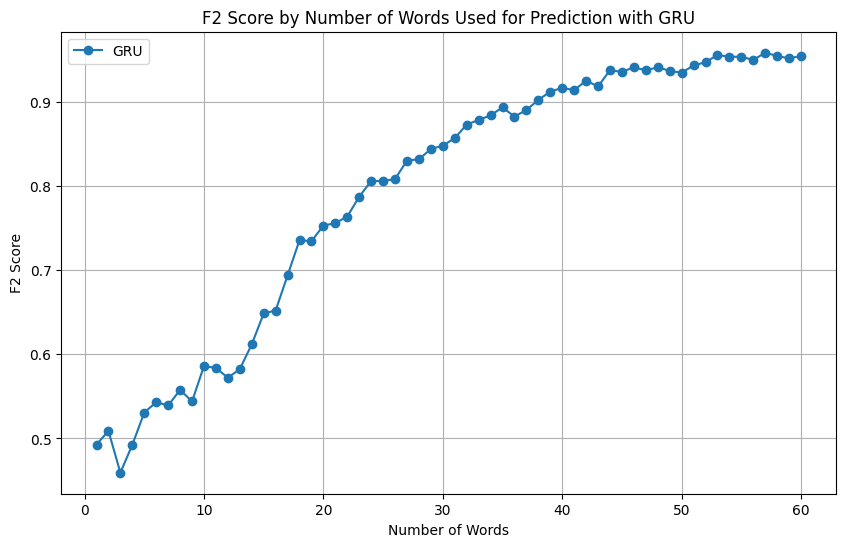

In [15]:
# 計算GRU的F2分數
f2_scores_gru = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for word_count in range(1, max_num_words+1):
    torch.cuda.empty_cache()

    train_words = filter_words_strict(train_df, word_count)
    test_words = filter_words_strict(test_df, word_count)

    if train_words.empty or test_words.empty:
        f2_scores_gru.append(0)
        continue

    train_grouped = train_words.groupby('post_id')['word_content'].apply(lambda x: ' '.join(x))
    test_grouped = test_words.groupby('post_id')['word_content'].apply(lambda x: ' '.join(x))
    train_labels = train_words.groupby('post_id')['label'].first()
    test_labels = test_words.groupby('post_id')['label'].first()

    X_train = vectorizer.fit_transform(train_grouped)
    X_test = vectorizer.transform(test_grouped)

    X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32).to(device).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device).unsqueeze(1)
    y_train_tensor = torch.tensor(train_labels.values, dtype=torch.float32).view(-1, 1).to(device)
    y_test_tensor = torch.tensor(test_labels.values, dtype=torch.float32).view(-1, 1).to(device)

    input_size = X_train_tensor.shape[2]
    hidden_size = 128
    num_layers = 2
    model = GRUModel(input_size, hidden_size, num_layers, 1).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predictions = (predictions.cpu().numpy() > 0.5).astype(int)
        f2 = fbeta_score(test_labels, predictions, beta=2)
        f2_scores_gru.append(f2)

# 繪製結果圖表
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_num_words+1), f2_scores_gru, marker='o', label='GRU')
plt.xlabel('Number of Words')
plt.ylabel('F2 Score')
plt.title('F2 Score by Number of Words Used for Prediction with GRU')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

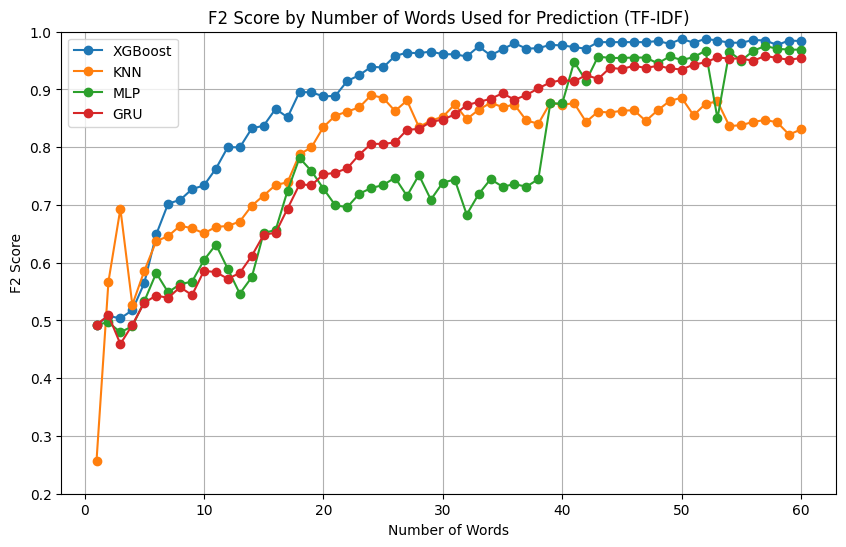

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_num_words + 1), f2_scores_xgb, marker='o', label='XGBoost')
plt.plot(range(1, max_num_words + 1), f2_scores_knn, marker='o', label='KNN')
plt.plot(range(1, max_num_words + 1), f2_scores_mlp, marker='o', label='MLP')
plt.plot(range(1, max_num_words + 1), f2_scores_gru, marker='o', label='GRU')
plt.xlabel('Number of Words')
plt.ylabel('F2 Score')
plt.title('F2 Score by Number of Words Used for Prediction (TF-IDF)')
plt.ylim(0.2, 1.0)  # fix y-axis range
plt.grid(True)
plt.legend(loc='upper left')
plt.show()